In [35]:
%matplotlib inline
import random
import time
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torch.nn.functional as F
import torch.optim as optim
from google.colab import drive

manualSeed = 420
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  420


In [2]:
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


**SETTING UP CONSTANTS**

In [10]:
dataroot = "/content/gdrive/My Drive/ML/cityscapes"
workers = 2
batch_size = 16
image_size = 256
# Number of channels in the training images. For color images this is 3
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64
# Learning rate for optimizers
lr = 0.0002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

**DEFINING THE DATASET**

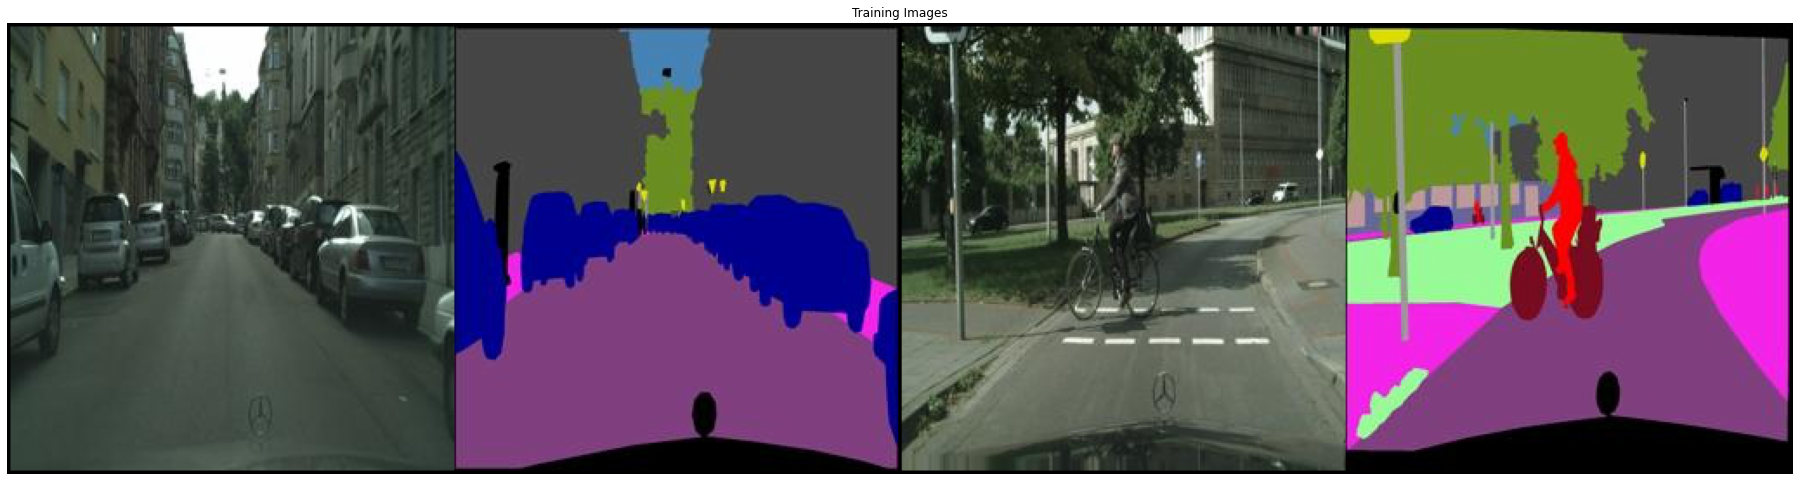

In [11]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(32,16))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:2], padding=2, normalize=True).cpu(),(1,2,0)))

**ARCHITECTURE**

Generator

In [12]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, padding_mode='replicate')
        self.batchnorm0 = nn.BatchNorm2d(32)
        self.pool0 = nn.MaxPool2d(kernel_size=2) # 256 -> 128
        self.enc_conv1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, padding_mode='replicate')
        self.batchnorm0 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2) # 128 -> 64
        self.enc_conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, padding_mode='replicate')
        self.batchnorm0 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2) # 64 -> 32
        self.enc_conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, padding_mode='replicate')
        self.batchnorm0 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2) # 32 -> 16

        self.bottleneck_conv = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, padding_mode='replicate')

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(size = 32, mode='bilinear', align_corners=False) # 16 -> 32
        self.dec_conv0 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1, padding_mode='replicate')
        self.upsample1 = nn.Upsample(size = 64, mode='bilinear', align_corners=False) # 32 -> 64
        self.dec_conv1 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1, padding_mode='replicate')
        self.upsample2 = nn.Upsample(size = 128, mode='bilinear', align_corners=False)  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1, padding_mode='replicate')
        self.upsample3 = nn.Upsample(size = 256, mode='bilinear', align_corners=False)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(in_channels=32, out_channels=3, kernel_size=3, padding=1, padding_mode='replicate')

    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.enc_conv0(x))) #128
        e1 = self.pool1(F.relu(self.enc_conv1(e0))) #64
        e2 = self.pool2(F.relu(self.enc_conv2(e1))) #32x128
        e3 = self.pool3(F.relu(self.enc_conv3(e2))) #16

        # bottleneck
        b = self.bottleneck_conv(F.relu(e3))

        # decoder
        d0 = self.dec_conv0(F.relu(self.upsample0(b)))#32x256
        d1 = self.dec_conv1(F.relu(self.upsample1(self.dec_conv0(torch.cat((e2, d0), dim=1)))))#64
        d2 = self.dec_conv2(F.relu(self.upsample2(self.dec_conv1(torch.cat((e1, d1), dim=1)))))#128
        d3 = self.dec_conv3(self.upsample3(self.dec_conv2(torch.cat((e0, d2), dim=1))))  # no activation
        return d3

Discriminator

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, padding_mode='replicate')
        self.batchnorm0 = nn.BatchNorm2d(32)
        self.pool0 = nn.MaxPool2d(kernel_size=2) # 256 -> 128
        self.enc_conv1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, padding_mode='replicate')
        self.batchnorm0 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2) # 128 -> 64
        self.enc_conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, padding_mode='replicate')
        self.batchnorm0 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2) # 64 -> 32
        self.enc_conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, padding_mode='replicate')
        self.batchnorm0 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2) # 32 -> 16

        self.fc = nn.Linear(256*16*16, 1)
        self.probs = nn.Sigmoid()

    def forward(self, x):
        e0 = self.pool0(F.relu(self.enc_conv0(x))) #128
        e1 = self.pool1(F.relu(self.enc_conv1(e0))) #64
        e2 = self.pool2(F.relu(self.enc_conv2(e1))) #32x128
        e3 = self.pool3(F.relu(self.enc_conv3(e2))) #16

        f = e3.view(e3.size(0), -1)
        logits = self.fc(f)
        probs = self.probs(logits)
        return probs

DEFINE LOSS AND OPTIMIZER

In [53]:
netD = Discriminator().to(device)
netG = Generator().to(device)

# Number of training epochs
num_epochs = 15
# lr
lr = 1e-4
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed = real_batch[0][:,:,:,:256].to(device)
# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=0.1*lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=5*lr, betas=(beta1, 0.999))

**TRAINING**

In [54]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    since = int(round(time.time()*1000))
    for i, data in enumerate(dataloader, 0):
        sample = data[0]
        
        img = sample[:,:,:,:256]
        img = img.to(device)

        mask = sample[:,:,:,256:]
        mask = mask.to(device)

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        b_size = mask.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(mask).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate fake image batch with G
        fake = netG(img)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)#????????
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost!!!!!!!!!!
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed image
        if (iters % 100 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

    
    time_elapsed = int(round(time.time()*1000)) - since
    print ('training time elapsed {}ms'.format(time_elapsed))

Starting Training Loop...
[0/15][0/218]	Loss_D: 1.3863	Loss_G: 0.6952	D(x): 0.4981	D(G(z)): 0.4981 / 0.4990
[0/15][50/218]	Loss_D: 1.3597	Loss_G: 0.6872	D(x): 0.5169	D(G(z)): 0.5033 / 0.5030
[0/15][100/218]	Loss_D: 1.3419	Loss_G: 0.6769	D(x): 0.5312	D(G(z)): 0.5080 / 0.5082
[0/15][150/218]	Loss_D: 1.3236	Loss_G: 0.6858	D(x): 0.5363	D(G(z)): 0.5036 / 0.5037
[0/15][200/218]	Loss_D: 1.3218	Loss_G: 0.6835	D(x): 0.5594	D(G(z)): 0.5184 / 0.5088
training time elapsed 56665ms
[1/15][0/218]	Loss_D: 1.2591	Loss_G: 0.7182	D(x): 0.5542	D(G(z)): 0.4875 / 0.4876
[1/15][50/218]	Loss_D: 1.1893	Loss_G: 0.7005	D(x): 0.6066	D(G(z)): 0.4974 / 0.4965
[1/15][100/218]	Loss_D: 1.0477	Loss_G: 0.7897	D(x): 0.6428	D(G(z)): 0.4538 / 0.4540
[1/15][150/218]	Loss_D: 0.9008	Loss_G: 0.7953	D(x): 0.7470	D(G(z)): 0.4551 / 0.4523
[1/15][200/218]	Loss_D: 0.6832	Loss_G: 1.3106	D(x): 0.6906	D(G(z)): 0.2677 / 0.2701
training time elapsed 58336ms
[2/15][0/218]	Loss_D: 0.5824	Loss_G: 1.1499	D(x): 0.8205	D(G(z)): 0.3184 / 0.317

Проверим что и как

(518, 4114, 3)


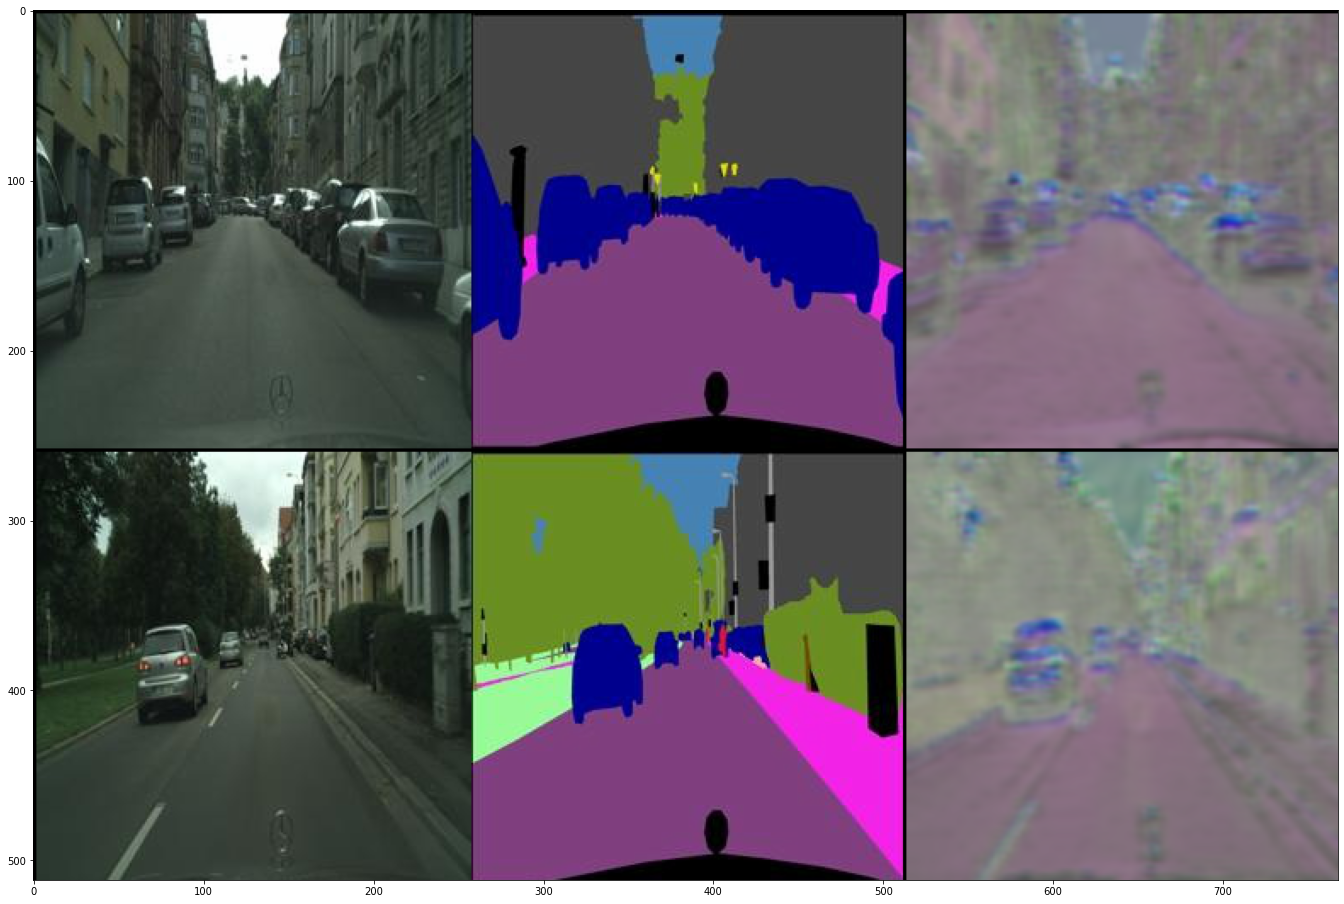

In [59]:
generation = -1

true_imgs = np.moveaxis(np.array(vutils.make_grid(real_batch[0], padding=2, normalize=True)), 0, -1)
gend_imgs = np.moveaxis(np.array(img_list[generation]), 0,-1)

result = np.zeros((512,768,3))
result[:,:512,:] = true_imgs[:512,:512,:]
result[:,512:,:] = gend_imgs[:512,:256,:]

plt.figure(figsize=(32,16))
plt.imshow(result)

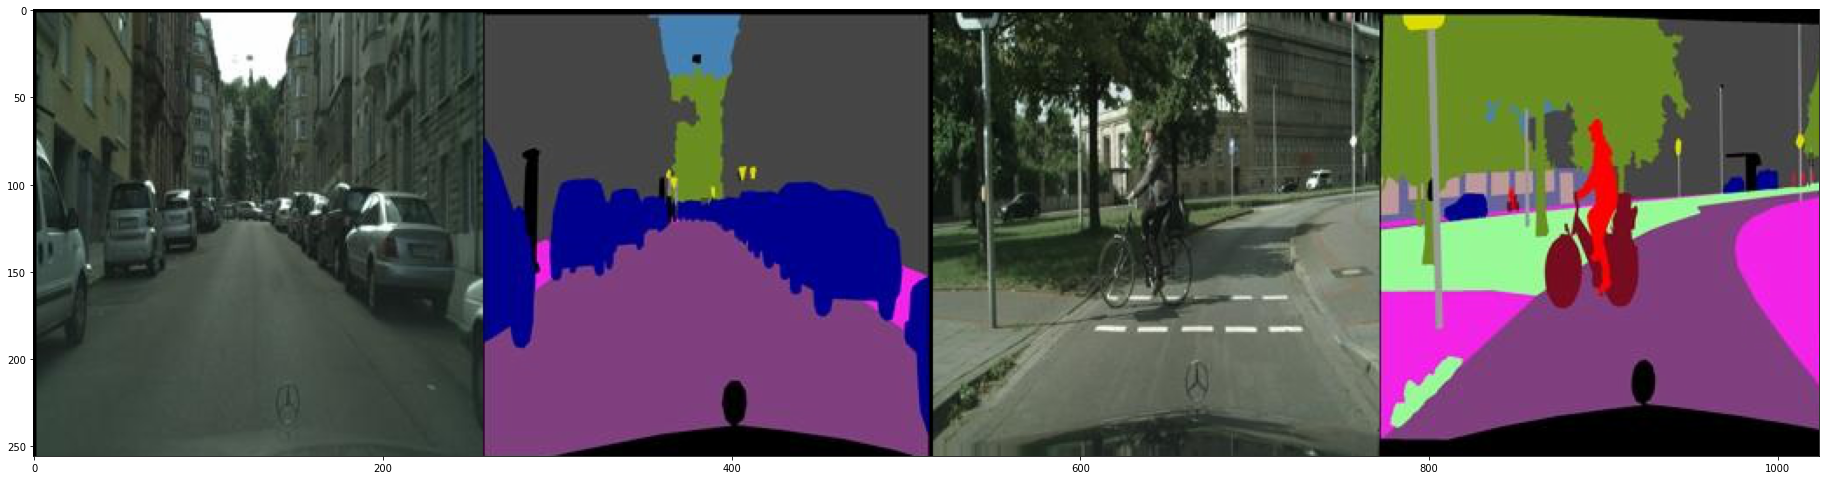

In [51]:
true_img = np.moveaxis(np.array(vutils.make_grid(real_batch[0], padding=2, normalize=True)), 0, -1)
plt.figure(figsize=(32,16))
plt.imshow(img[:256,:1024,:])

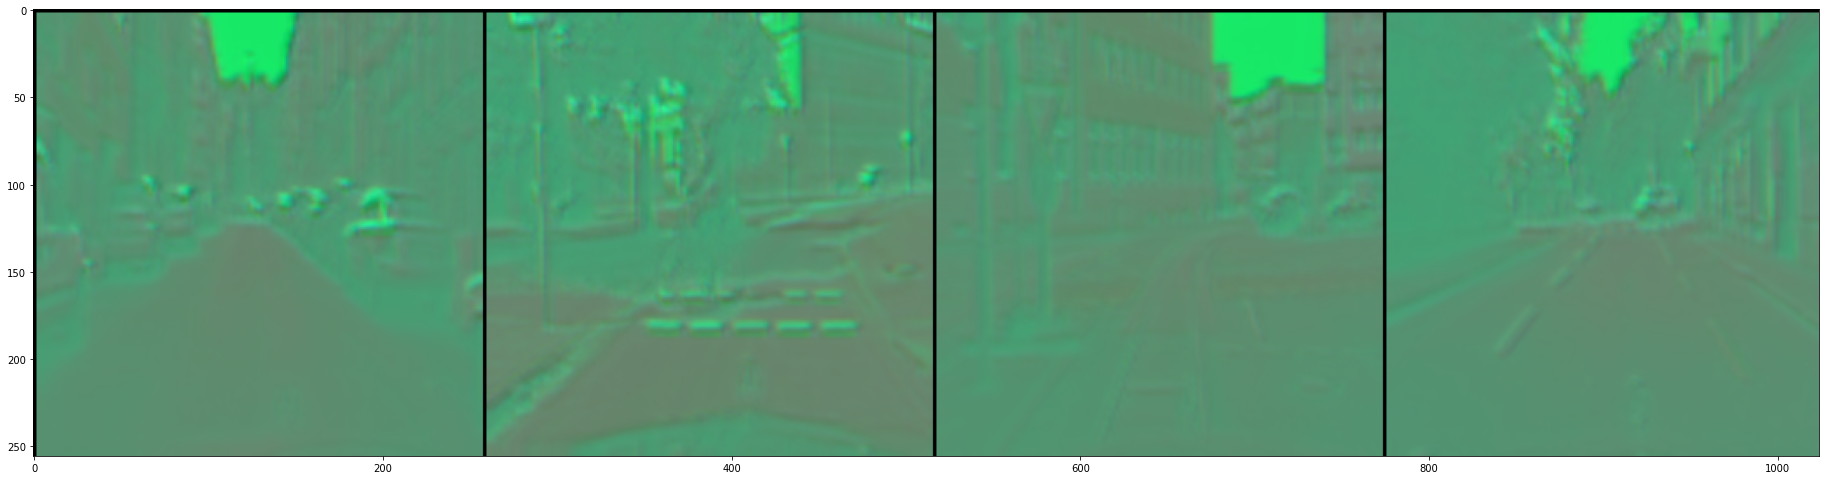

In [52]:
img = np.moveaxis(np.array(img_list[0]), 0,-1)
plt.figure(figsize=(32,16))
plt.imshow(img[:256,:1024,:])

